#Exercise 1

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# Set random seed for reproducibility
np.random.seed(42)

##1. Data loading
We first download and load the dataset.

In [6]:
# 1. Download the dataset
!wget -q https://www.dropbox.com/s/bal044f83ezxiia/ovariancancer_obs.csv
!wget -q https://www.dropbox.com/s/r52sn5gmkd3y797/ovariancancer_grp.csv

# 2. Load the data
ovariancancer_obs_path = './ovariancancer_obs.csv'
ovariancancer_grp_path = './ovariancancer_grp.csv'

# Load Matrix A (Observations)
# Transpose as per instructions: Each column represents a patient [cite: 4, 16]
A = np.genfromtxt(ovariancancer_obs_path, delimiter=',').transpose()

# Load Groups (Labels)
f = open(ovariancancer_grp_path)
grp = np.array(f.read().split("\n"))
f.close()

# Clean up empty strings if any result from split
grp = np.array([g for g in grp if g])

# Dimensions
n_features = A.shape[0]
n_patients = A.shape[1]

print(f'Matrix A shape: {A.shape} ({n_features} features, {n_patients} patients)')

Matrix A shape: (4000, 216) (4000 features, 216 patients)


In [ ]:
grp

##2. Implementation of Randomized SVD

We implement the Randomized SVD algorithm.
* Step A: Generate a Gaussian random matrix $\Omega$.
* Step B: Form the sample matrix $Y = A\Omega$.
* Step C: Compute orthonormal basis $Q$ for the range of $Y$ (using QR decomposition).
* Step D: Form $B = Q^T A$.
* Step E: Compute exact SVD of the small matrix $B$.
* Step F: Recover $U = Q \hat{U}$.

In [7]:
def randomized_svd(M, k, oversampling=0):
    """
    Computes the randomized SVD of matrix M.

    Parameters:
    M: Input matrix (m x n)
    k: Target rank
    oversampling: Additional number of random vectors (p)

    Returns:
    U, S, Vt: Approximate SVD components
    """
    m, n = M.shape
    p = oversampling

    # 1. Generate Gaussian Random Matrix Omega (n x k+p)
    Omega = np.random.normal(0, 1, size=(n, k + p))

    # 2. Form the sample matrix Y = M * Omega
    Y = M @ Omega

    # 3. Form orthonormal basis Q (m x k+p)
    Q, _ = np.linalg.qr(Y)

    # 4. Form B = Q.T * M
    B = Q.T @ M

    # 5. Compute Exact SVD of B
    U_hat, S, Vt = np.linalg.svd(B, full_matrices=False)

    # 6. Compute U = Q * U_hat
    U = Q @ U_hat

    # Return top k components (though we computed k+p)
    return U[:, :k], S[:k], Vt[:k, :]

## 3. PCA and Singular Value Analysis
We perform PCA using Exact SVD and compare the singular values with those obtained via rSVD for various ranks.

Exact SVD Time: 0.1795s


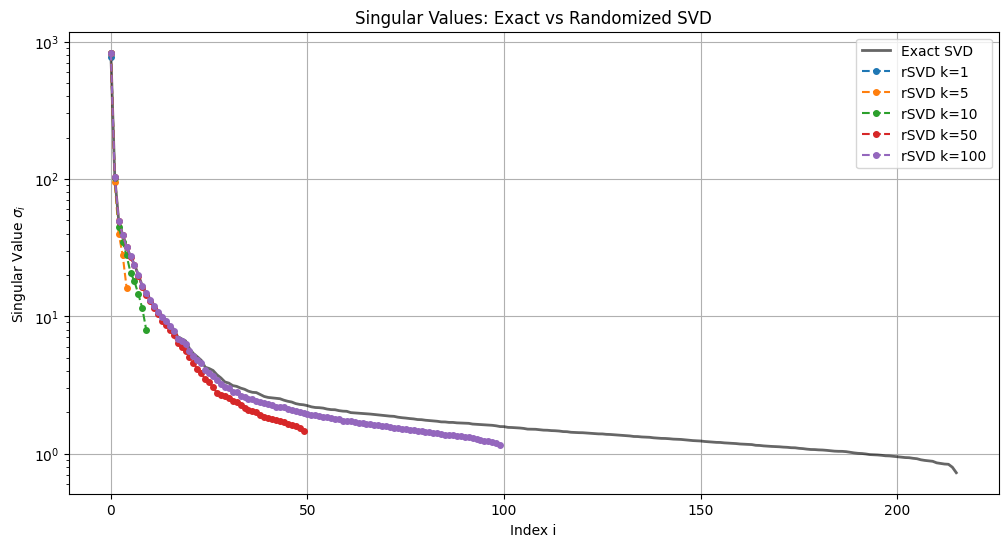

In [8]:
# --- Exact SVD ---
start_time = time.time()
U_exact, S_exact, Vt_exact = np.linalg.svd(A, full_matrices=False)
exact_time = time.time() - start_time
print(f"Exact SVD Time: {exact_time:.4f}s")

# --- Plotting Singular Values ---
k_values = [1, 5, 10, 50, 100]

plt.figure(figsize=(12, 6))
plt.plot(S_exact, 'k-', label='Exact SVD', linewidth=2, alpha=0.6)

# --- Randomized SVD Computations ---
rsvd_results = {}

for k in k_values:
    # Perform rSVD
    U_r, S_r, Vt_r = randomized_svd(A, k=k, oversampling=0)
    rsvd_results[k] = (U_r, S_r, Vt_r)

    # Plot approximate singular values
    plt.plot(range(k), S_r, 'o--', label=f'rSVD k={k}', markersize=4)

plt.title('Singular Values: Exact vs Randomized SVD')
plt.xlabel('Index i')
plt.ylabel(r'Singular Value $\sigma_i$')
plt.yscale('log') # Log scale to see the drop-off better
plt.legend()
plt.grid(True)
plt.show()

**Comment:** The singular values from the Randomized SVD closely match the exact singular values for the leading components. However, for higher $k$ (e.g., $k=100$), the randomized algorithm (without oversampling) might start to deviate slightly at the tail end of the spectrum if the spectrum does not decay rapidly enough. The log-scale plot confirms that the first few singular values capture the majority of the variance.

## 4. Reconstruction Error
We calculate the reconstruction error $\|A - A_k\|_F / \|A\|_F$ for exact SVD, rSVD, and rSVD with 50% oversampling.

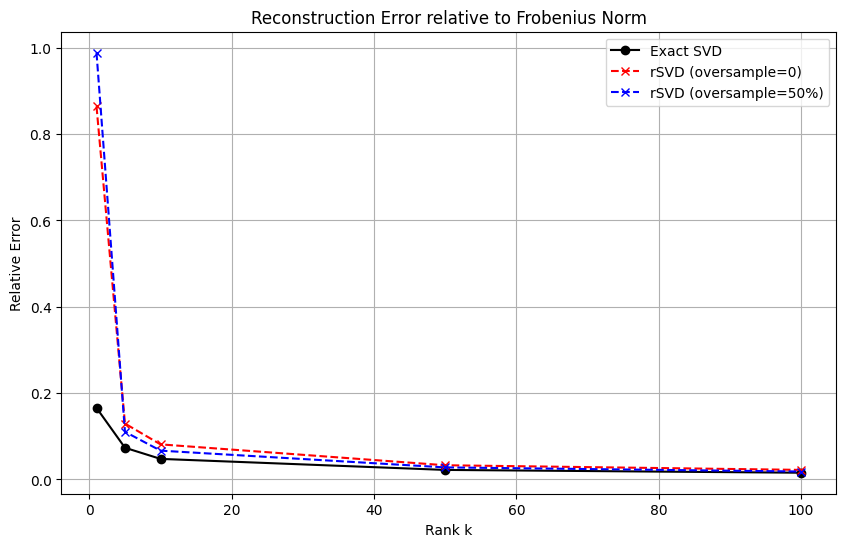

In [9]:
# Helper to compute Frobenius reconstruction error
def reconstruction_error(A, U, S, Vt):
    # Reconstruct A_k
    # Note: U, S, Vt are already truncated to rank k in our storage
    # Expand S to diagonal matrix
    A_k = (U * S) @ Vt
    diff = A - A_k
    return np.linalg.norm(diff, 'fro') / np.linalg.norm(A, 'fro')

errors_exact = []
errors_rsvd = []
errors_rsvd_over = []

for k in k_values:
    # 1. Exact SVD Error (truncating the full exact SVD computed earlier)
    U_k = U_exact[:, :k]
    S_k = S_exact[:k]
    Vt_k = Vt_exact[:k, :]
    errors_exact.append(reconstruction_error(A, U_k, S_k, Vt_k))

    # 2. Randomized SVD Error (No oversampling)
    U_r, S_r, Vt_r = randomized_svd(A, k=k, oversampling=0)
    errors_rsvd.append(reconstruction_error(A, U_r, S_r, Vt_r))

    # 3. Randomized SVD Error (+50% oversampling)
    # p = round(1.5 * k) - k = round(0.5 * k)
    p = int(np.round(0.5 * k))
    U_ro, S_ro, Vt_ro = randomized_svd(A, k=k, oversampling=p)
    errors_rsvd_over.append(reconstruction_error(A, U_ro, S_ro, Vt_ro))

# Plotting Reconstruction Errors
plt.figure(figsize=(10, 6))
plt.plot(k_values, errors_exact, 'ko-', label='Exact SVD')
plt.plot(k_values, errors_rsvd, 'rx--', label='rSVD (oversample=0)')
plt.plot(k_values, errors_rsvd_over, 'bx--', label='rSVD (oversample=50%)')

plt.title('Reconstruction Error relative to Frobenius Norm')
plt.xlabel('Rank k')
plt.ylabel('Relative Error')
plt.legend()
plt.grid(True)
plt.show()

**Comment:**
As expected, the Exact SVD provides the lowest possible reconstruction error (Eckart-Young theorem). The Randomized SVD errors are very close to the exact ones. Adding 50% oversampling (increasing the random matrix columns) improves the accuracy of the basis $Q$, making the error curve nearly indistinguishable from the Exact SVD, especially for larger $k$.

##5. Scatterplot of Principal Components
We project the patients onto the first two principal components. Since <code>grp</code> contains the labels, we color-code them.

**Important:** The dataset is transposed so that columns are patients. PCA projects the columns (patients) into the feature space defined by $U$. The coordinates of the patients in the PC space are given by $V^T$ (scaled by $S$) or by projecting $A^T$ onto $U$.
Specifically, $A = U \Sigma V^T$. The representation of columns (patients) in the reduced space is $V^T$ scaled by $\Sigma$. Alternatively, we project the patients $A^T$ onto the principal components (eigenvectors of covariance).
The principal components of the samples (columns of A) are the columns of $V$ (or rows of $V^T$).

Unique groups: ['Cancer' 'Normal']


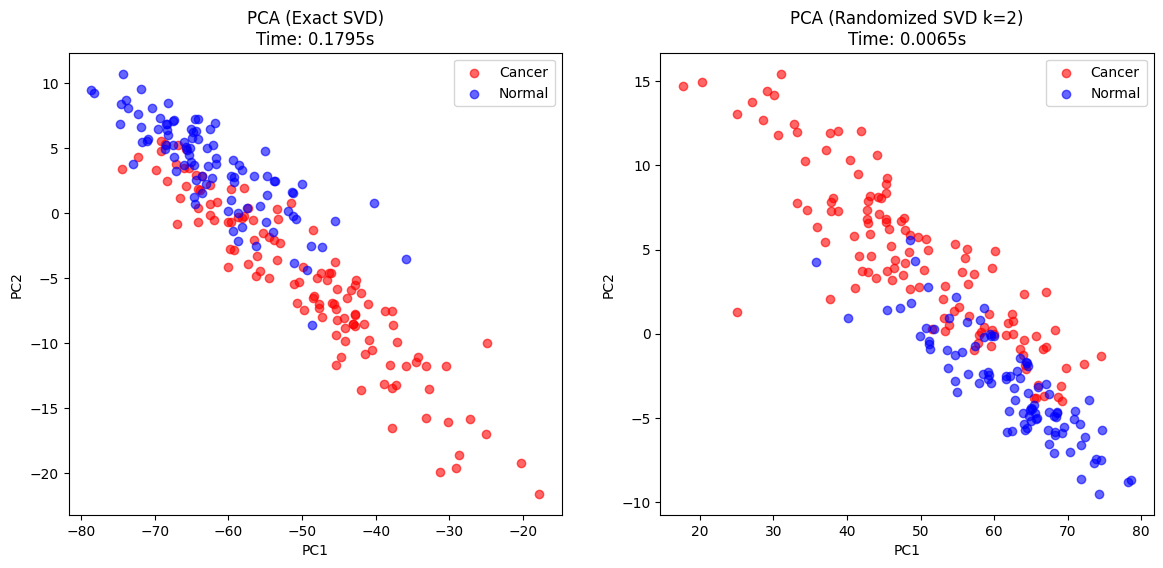

Execution Time Exact SVD: 0.17952 s
Execution Time rSVD (k=2): 0.00646 s


In [11]:
# Define colors
# 'Cancer' group vs others.
# Note: Ensure label matching is correct based on dataset content
print("Unique groups:", np.unique(grp))
cancer_mask = (grp == 'Cancer')
normal_mask = (grp != 'Cancer')

# --- Exact SVD Projection ---
# Projecting patients onto first 2 PCs:
# Coordinates are typically (S * V^T) for the first 2 rows
coords_exact = np.diag(S_exact[:2]) @ Vt_exact[:2, :]

plt.figure(figsize=(14, 6))

# Plot 1: Exact SVD
plt.subplot(1, 2, 1)
plt.scatter(coords_exact[0, cancer_mask], coords_exact[1, cancer_mask], c='r', label='Cancer', alpha=0.6)
plt.scatter(coords_exact[0, normal_mask], coords_exact[1, normal_mask], c='b', label='Normal', alpha=0.6)
plt.title(f'PCA (Exact SVD)\nTime: {exact_time:.4f}s')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

# --- Randomized SVD Projection (k=2) ---
start_time_r = time.time()
U_r2, S_r2, Vt_r2 = randomized_svd(A, k=2, oversampling=2) # Using small oversampling for stability
rsvd_time = time.time() - start_time_r

coords_rsvd = np.diag(S_r2) @ Vt_r2

# Plot 2: Randomized SVD
plt.subplot(1, 2, 2)
plt.scatter(coords_rsvd[0, cancer_mask], coords_rsvd[1, cancer_mask], c='r', label='Cancer', alpha=0.6)
plt.scatter(coords_rsvd[0, normal_mask], coords_rsvd[1, normal_mask], c='b', label='Normal', alpha=0.6)
plt.title(f'PCA (Randomized SVD k=2)\nTime: {rsvd_time:.4f}s')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

plt.show()

print(f"Execution Time Exact SVD: {exact_time:.5f} s")
print(f"Execution Time rSVD (k=2): {rsvd_time:.5f} s")

**Comment on Execution Time:**
The randomized SVD with $k=2$ is significantly faster than the full Exact SVD because it avoids decomposing the full matrix, operating instead on a much smaller matrix $B$. The scatter plots are very similar (with flipped signs, which is mathematically valid in SVD).

#Exercise 2

## 1. Data Setup

In [ ]:
import numpy as np


X = np.genfromtxt('X.dat')
y = np.genfromtxt('y.dat')


print(f"Data shape: X={X.shape}, y={y.shape}")

##2. SGD Implementation
The objective function is:
$$
J(w) = \frac{1}{N} \sum_{i=1}^N \log(1 + \exp(-y_i w^T x_i))
$$
The gradient for a single sample $i$ (Batch size = 1) is:
$$
\nabla_w J_i(w) = \frac{-y_i x_i}{1 + \exp(y_i w^T x_i)}
$$
We perform SGD for 5000 iterations.

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def loss_function(X, y, w):
    """Compute average loss over the dataset."""
    N = X.shape[0]
    # loss = log(1 + exp(-y * wTx))
    # Using stable computation: log(1+exp(-z)) approx max(0, -z) + log(1+exp(-|z|))
    z = y * (X @ w)
    return np.mean(np.log(1 + np.exp(-z)))

def sgd_solver(X, y, iterations=5000, lr_type='constant', eta0=0.5):
    N, d = X.shape
    w = np.zeros(d) # Initialize to zero

    loss_history = []

    for k in range(iterations):
        # 1. Select random sample (Batch size = 1)
        idx = np.random.randint(0, N)
        xi = X[idx]
        yi = y[idx]

        # 2. Compute Gradient
        # grad = -yi * xi / (1 + exp(yi * w.T * xi))
        linear_term = yi * np.dot(w, xi)

        # Sigmoid(-z) = 1 / (1 + exp(z))
        # We need 1 / (1 + exp(linear_term))
        prob_factor = 1.0 / (1.0 + np.exp(linear_term))

        grad = -yi * xi * prob_factor

        # 3. Determine Learning Rate
        if lr_type == 'constant':
            eta = eta0
        elif lr_type == 'decay':
            # k is iteration number (0-based here, formula usually 1-based or 0-based)
            # Prompt: eta_k = eta0 / (1 + k/100)
            eta = eta0 / (1.0 + k / 100.0)

        # 4. Update
        w = w - eta * grad

        # Record loss every 50 steps to monitor
        if k % 50 == 0:
            loss_history.append(loss_function(X, y, w))

    return w, loss_history

# --- Run SGD ---
# Case 1: Constant LR = 0.5 [cite: 52]
w_const, loss_const = sgd_solver(X, y, iterations=5000, lr_type='constant', eta0=0.5)

# Case 2: Decaying LR, eta0 = 0.05 [cite: 54, 55, 56]
w_decay, loss_decay = sgd_solver(X, y, iterations=5000, lr_type='decay', eta0=0.05)

# --- Plot Results ---
plt.figure(figsize=(10, 5))
plt.plot(range(0, 5000, 50), loss_const, label=r'Constant LR $\eta=0.5$')
plt.plot(range(0, 5000, 50), loss_decay, label=r'Decaying LR $\eta_k$')
plt.xlabel('Iterations')
plt.ylabel('Loss $J(w)$')
plt.title('SGD Convergence Comparison')
plt.legend()
plt.grid(True)
plt.show()

**Comment:**
* *Constant Learning Rate:* With a high constant rate ($\eta=0.5$), the loss decreases initially but usually exhibits oscillation or noise near the minimum because the step size is too large to settle into the optimal point finely.
* *Decaying Learning Rate:* The decaying rate starts smaller ($\eta_0=0.05$) and decreases further. This ensures that as the algorithm approaches the minimum, the steps get smaller, reducing variance and allowing for convergence to a tighter solution. The curve appears smoother.

# Exercise 3



1.   Consider an $L$-layer neural network.Let $x^{(0)}$ be the input vector.Let $W^{(l)}$ be the weight matrix and $b^{(l)}$ be the bias vector for layer $l \in \{1, \dots, L\}$.The output of layer $l$, denoted $x^{(l)}$, is given by:$$x^{(l)} = s(W^{(l)} x^{(l-1)} + b^{(l)})$$Since the activation function is linear, $s(z) = z$, this simplifies to:$$x^{(l)} = W^{(l)} x^{(l-1)} + b^{(l)}$$For a 2-layer network (for simplicity, but extends to $L$ by induction):$$x^{(2)} = W^{(2)} (W^{(1)} x^{(0)} + b^{(1)}) + b^{(2)}$$$$x^{(2)} = (W^{(2)} W^{(1)}) x^{(0)} + (W^{(2)} b^{(1)} + b^{(2)})$$We can define a new effective weight matrix $W_{new} = W^{(2)} W^{(1)}$ and a new effective bias $b_{new} = W^{(2)} b^{(1)} + b^{(2)}$.Thus, $x^{(2)} = W_{new} x^{(0)} + b_{new}$, which describes a single-layer linear network.By induction, any composition of linear transformations is a linear transformation. Therefore, a deep linear network collapses to a single linear layer.
2. We analyze the behavior of the functions around $x=0$. If the function can be approximated as $s(x) \approx c x$ (linear) or $s(x) \approx cx + d$ (affine) with a significant slope, the network behaves linearly for small variances.
* *Sigmoid:* $s(x) = \frac{1}{1+e^{-x}}$Taylor expansion at $x=0$:$$s(x) \approx s(0) + s'(0)x = 0.5 + 0.25x$$This is an affine transformation. A composition of affine transformations is affine. While strictly "linear" means $y=Wx$, in neural networks, "linear" often encompasses affine layers (weights + bias). For small inputs, sigmoid behaves like a linear function with a bias shift. However, the question asks "equivalent to a linear network". If bias is allowed, Yes (it is affine). If strictly linear ($s(x) \approx x$), No (due to the 0.5 offset). Given the context of "linear network" usually allowing biases: Equivalent to Affine.
* *Tanh:* $s(x) = \tanh(x)$Taylor expansion at $x=0$:$$s(x) \approx s(0) + s'(0)x = 0 + 1 \cdot x = x$$The function passes through the origin and is approximately linear with slope 1 for small $x$.Conclusion: Equivalent to Linear.
* *ReLU:* $s(x) = \max(0, x)$ReLU is non-differentiable at 0, but we look at the distribution.For $x \sim N(0, \sigma^2)$, half the values are negative and become 0.$$s(x) = \begin{cases} x & x > 0 \\ 0 & x \le 0 \end{cases}$$This "rectification" destroys information (clips negative half). Even for infinitely small variance $\sigma$, the nonlinearity persists (it is not locally linear in a way that preserves the full Gaussian structure; it transforms a Gaussian into a rectified Gaussian).Conclusion: NOT equivalent to Linear.
* *SELU:* $s(x) = \lambda x$ if $x>0$, $\alpha(e^x - 1)$ if $x \le 0$.Where $\lambda \approx 1.05, \alpha \approx 1.76$.Taylor expansion for the negative part around 0: $\alpha(e^x - 1) \approx \alpha(1 + x - 1) = \alpha x$.So, for small $x$:$$s(x) \approx \begin{cases} \lambda x & x > 0 \\ \alpha x & x \le 0 \end{cases}$$Since $\lambda \neq \alpha$ ($1.05 \neq 1.76$), the slope changes depending on the sign of $x$. This is a piecewise linear function with a "kink" at 0. It does not behave as a single linear scalar multiplication.Conclusion: NOT equivalent to Linear.

Summary Answer:Only $\tanh(x)$ makes the deep network strictly equivalent to a linear network.(Sigmoid makes it Affine; ReLU and SELU remain non-linear due to the rectifying/kink nature at 0).

